# Proyecto ML for Engineering - Grupo 1

## Integrantes
- Juan Camilo Rojas Hernández (202121526)  
- Sergio Andrés Canar Lozano (202020383)  
- Wilman Sánchez Hernández (202116779)  

---

# Machine Learning Adversarial: **Fast Gradient Sign Method (FGSM) en el Reconocimiento de Rostros**

El *Machine Learning Adversarial* (MLA) se refiere a la manipulación de sistemas de *Machine Learning* (ML) e *Inteligencia Artificial* (IA) con el propósito de comprometer su desempeño. Este campo de estudio se enfoca en identificar y explotar las vulnerabilidades presentes en dichos sistemas, lo que afecta su capacidad para realizar predicciones y cumplir tareas de manera efectiva.

El MLA abarca el diseño y análisis de técnicas que buscan perturbar el funcionamiento de los sistemas de ML en cualquier etapa del proceso, ya sea durante el desarrollo, el entrenamiento o la predicción. Los métodos de MLA tienen el objetivo de evaluar la robustez de los modelos y proponer estrategias que fortalezcan su desempeño ante posibles ataques adversarios. 

Actualmente, existen diversas técnicas para realizar ataques adversariales en sistemas de ML. Una de las más utilizadas es el **Fast Gradient Sign Method** (FGSM, por sus siglas en inglés). Este método está diseñado específicamente para atacar redes neuronales, aprovechando la forma en que estas aprenden, es decir, a través de sus gradientes.

El FGSM utiliza el gradiente de la función de pérdida con respecto a los datos de entrada y ajusta estos datos para maximizar la pérdida del modelo. En términos generales, el ataque se lleva a cabo en los siguientes pasos:

1. **Cálculo del gradiente**: Se obtiene el gradiente de la función de error respecto a los datos de entrada.  
2. **Perturbación adversarial**: Se calcula una perturbación aplicando el signo de las derivadas multiplicado por una constante, denominada épsilon ($\epsilon$), que controla la magnitud de la alteración.  
3. **Generación del ejemplo adversarial**: La perturbación se suma a los datos originales para generar un nuevo conjunto de datos, diseñados específicamente para engañar al modelo.

Este proceso se resume en la siguiente imagen:

<div style="text-align: center;">
  <img src="./resources/fgsm_example_final.png" alt="Ejemplo FGGSA" width="1000">
</div>

En la imagen, $x$ representa la entrada correctamente clasificada como "Roger Federer", $y$ es la etiqueta correspondiente, $\theta$ denota los parámetros del modelo y $J(\theta, x, y)$ es la función de pérdida utilizada para entrenar el modelo. 

De esta forma el ataque FGSM aprovecha el gradiente de la pérdida respecto a los datos de entrada, $\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$, el cual es retropropagado para maximizar la pérdida. A partir de este gradiente, se ajustan los datos utilizando un hiperparámetro $\epsilon$ (0.3 en este caso), siguiendo la dirección del signo del gradiente, $sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$. Este proceso genera una imagen perturbada que el modelo clasifica incorrectamente; en este ejemplo, la entrada inicial "Roger Federer" es alterada y clasificada erróneamente como "Camila Cabello".

En este proyecto evaluaremos el desempeño de distintas arquitecturas de [ResNet](https://arxiv.org/pdf/1512.03385), utilizando sus [implementaciones en PyTorch y pesos preentrenados en ImageNet](https://pytorch.org/hub/pytorch_vision_resnet/) para entrenarlas en la tarea de reconocimiento de rostros de celebridades. Usaremos un pequeño dataset disponible en [Kaggle](https://www.kaggle.com/datasets/vasukipatel/face-recognition-dataset).

El objetivo es determinar cuál de estas arquitecturas es más susceptible al ataque FGSM. A continuación, mostraremos cómo se realiza el ataque en ResNet18 y presentaremos los resultados obtenidos en esta tarea.



### Comenzaremos con definir algunas cosas necesarias para la implementación del FGSM: Imports, Setup de CUDA y los paths para la carga de datos

#### Imports

In [1]:
import os 
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import CelebFacesDataset
from model import ResNet, ResidualBlock, get_resnet101_model, get_resnet18_model

#### CUDA Settings

In [2]:
# Configuración para usar CUDA
use_cuda = torch.cuda.is_available()

# Establecer una semilla manual para CUDA para asegurar la reproducibilidad
torch.cuda.manual_seed(42)

# Definir el dispositivo a usar: 'cuda' si está disponible y se desea usar, de lo contrario 'cpu'
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Imprimir el dispositivo que se está utilizando
print(device)

cuda


#### Paths

In [3]:
this_dir = os.getcwd() # Obtener el directorio actual
data_dir = os.path.join(this_dir, 'data') # Directorio de los datos
img_dir = os.path.join(data_dir, 'face_recognition', 'Faces') # Directorio de las imágenes
data_path = os.path.join(data_dir, 'face_recognition', 'dataset_faces.csv') # Directorio del archivo csv con los datos de las imágenes y las etiquetas

### Crear Datasets y Dataloaders

Ahora procederemos a crear nuestros datasets y dataloaders. En este caso, nos enfocaremos únicamente en el conjunto de prueba, ya que queremos modificar los gradientes del modelo previamente entrenado, si deseas ver como se entrenaron los modelos usados en este proyecto puedes revisar `train_test.py`. 

En esta sección, definimos las transformaciones necesarias para nuestras imágenes y cargamos los datos en el dataframe correspondiente. A partir de este dataframe, creamos nuestro dataset utilizando la clase `CelebFacesDataset` (la implementación de esta clase se encuentra en el archivo `dataset.py`).

Posteriormente, dividimos los datos en conjuntos de entrenamiento y prueba y finalmente configuramos nuestro modelo para que se ajuste al número de clases presentes en el dataset, que en este caso es 31. Puedes cambiar el modelo utilizado quitando el comentario que se encuentra en esta celda, solo asegurate de cargar los pesos que le correspondan al modelo que quieras probar.


In [4]:
# Dataset 
# Definir el conjunto de transformaciones a aplicar a las imágenes
transforms_set = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar imágenes a 224x224
    transforms.ToTensor(),  # Convertir imágenes a tensor
    transforms.Normalize(mean=[0.6389, 0.4773, 0.4056], std=[0.2343, 0.1996, 0.1831]),  # Normalizar imágenes con la media y desviación estándar (Calculadas en dataset.py)
])

# Cargar el conjunto de datos desde un archivo CSV
data = pd.read_csv(data_path)

# Crear un objeto de conjunto de datos con los datos cargados y las transformaciones
dataset = CelebFacesDataset(df=data, root_dir=img_dir, transform=transforms_set)

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
_, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Crear un DataLoader para el conjunto de datos de prueba
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Definir el número de clases en el conjunto de datos
num_classes = 31

# Cargar el modelo preentrenado (Puedes cambiar el modelo a cargar) 
model = get_resnet18_model(num_classes=num_classes)
# model = get_resnet101_model(num_classes=num_classes)
# model = ResNet(ResidualBlock, [3, 4, 6, 3, 2], num_classes=num_classes).to(device)

### Preparación ataque FGSM 

En esta celda definiremos los epsilon ($\epsilon$) para atacar el modelo que escogimos previamente. Además, aquí cargaremos los pesos de la red previamente entrenada para evaluar el modelo. 

In [5]:
# Definir los valores de epsilon para el ataque FGSM
epsilons = [0, 0.0001, 0.001, 0.005, 0.007, 0.01, 0.1, 0.3, 0.5, 1]

# Ruta del modelo preentrenado
pretrained_model = 'models/resnet18_celeb_faces.pth'

# Cargar los pesos del modelo preentrenado
model.load_state_dict(torch.load(pretrained_model, map_location=device, weights_only=True))

# Imprimir confirmación de que el modelo ha sido cargado
print('Model loaded!')

# Imprimir la longitud de la lista de epsilons
print(len(epsilons))

Model loaded!
10


## Ataque FGSM

Con todo el proceso previamente realizado, ya contamos con las herramientas necesarias para crear ejemplos adversariales al perturbar las imágenes de entrada del modelo. Este procedimiento se realiza en la función `fgsm_attack`, que recibe tres parámetros de entrada: 

1. **La imagen original** ($x$).
2. **Epsilon** ($\epsilon$), que es la perturbación por pixel que aplicaremos a la imagen.
3. **Data_grad**, que corresponde al gradiente de la función de pérdida respecto a la imagen de entrada, $\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$.

Este proceso se basa en la siguiente ecuación, la cual nos genera la imagen perturbada:

$$
imagen\_perturbada = imagen + epsilon*signo(data\_grad) = x + \epsilon * signo(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))
$$

De esta manera, la imagen original $x$ se ajusta mediante el gradiente de la función de pérdida, generando un ejemplo adversarial que el modelo podría clasificar incorrectamente.




In [6]:
def fgsm_attack(image, epsilon, data_grad):
    """
    Realiza un ataque de Gradiente Signado de una Sola Iteración (FGSM) en una imagen.

    Args:
        image (torch.Tensor): La imagen de entrada sobre la cual se realizará el ataque.
        epsilon (float): La magnitud del perturbación que se aplicará a la imagen.
        data_grad (torch.Tensor): El gradiente de los datos con respecto a la pérdida.

    Returns:
        torch.Tensor: La imagen perturbada resultante después de aplicar el ataque FGSM.
    """
    # Obtener el signo del gradiente
    sign_data_grad = data_grad.sign()
    # Generar la imagen perturbada usando el signo del gradiente y la magnitud de la perturbación (epsilon) como se muestra en la ecuación de ataque FGSM
    perturbed_image = image + epsilon*sign_data_grad
    # Asegurarse de que la imagen perturbada esté dentro del rango de valores permitidos [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Retornar la imagen perturbada
    return perturbed_image


def denormalize(batch, mean=[0.6389, 0.4773, 0.4056], std=[0.2343, 0.1996, 0.1831]):
    """
    Desnormaliza un lote de imágenes utilizando la media y la desviación estándar proporcionadas.

    Parámetros:
    batch (torch.Tensor): Lote de imágenes normalizadas con forma (N, C, H, W).
    mean (list o torch.Tensor, opcional): Media utilizada para la normalización. Por defecto es [0.6389, 0.4773, 0.4056].
    std (list o torch.Tensor, opcional): Desviación estándar utilizada para la normalización. Por defecto es [0.2343, 0.1996, 0.1831].

    Retorna:
    torch.Tensor: Lote de imágenes desnormalizadas con la misma forma que el lote de entrada.
    """
    
    if isinstance(mean, list): 
        mean = torch.tensor(mean).to(device=device) # Convertir la media a un tensor y moverlo al device
    if isinstance(std, list): 
        std = torch.tensor(std).to(device=device) # Convertir la desviación estándar a un tensor y moverlo al device
    return batch * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1) # Desnormalizar el lote de imágenes y retornarlo

def normalize(batch, mean=[0.6389, 0.4773, 0.4056], std=[0.2343, 0.1996, 0.1831]):
    """
    Normaliza un lote de imágenes utilizando la media y desviación estándar proporcionadas.

    Args:
        batch (torch.Tensor): Lote de imágenes a normalizar con forma (N, C, H, W), donde N es el número de imágenes,
                              C es el número de canales, H es la altura y W es el ancho.
        mean (list o torch.Tensor, opcional): Media para cada canal. Por defecto es [0.6389, 0.4773, 0.4056].
        std (list o torch.Tensor, opcional): Desviación estándar para cada canal. Por defecto es [0.2343, 0.1996, 0.1831].

    Returns:
        torch.Tensor: Lote de imágenes normalizadas.
    """
    if isinstance(mean, list): 
        mean = torch.tensor(mean).to(device=device) # Convertir la media a un tensor y moverlo al device
    if isinstance(std, list):
        std = torch.tensor(std).to(device=device) # Convertir la desviación estándar a un tensor y moverlo al device
    return (batch - mean.view(1, 3, 1, 1)) / std.view(1, 3, 1, 1) # Normalizar el lote de imágenes y retornarlo

### Atacar el modelo con la función `test_with_FGSM`

Ahora utilizaremos la función `test_with_FGSM` que evalúa el rendimiento de un modelo cuando se le aplica el ataque FGSM sobre el conjunto de datos de prueba que creamos previamente. El objetivo de la función es medir la precisión del modelo al clasificar imágenes perturbadas por el ataque adversarial con distintos epsilon.

Primero, la función pone el modelo en modo de evaluación y recorre todas las imágenes del conjunto de prueba. Para cada imagen, calcula su predicción inicial y verifica si esta es correcta. Si la predicción es correcta, la función calcula la pérdida y luego realiza la retropropagación para obtener los gradientes respecto a la imagen de entrada. Estos gradientes se utilizan para generar la perturbación adversarial a través del ataque FGSM, el cual ajusta la imagen original en la dirección que maximiza la pérdida del modelo.

Una vez que se genera la imagen perturbada, se pasa nuevamente a través del modelo para obtener la predicción final. Si la predicción de la imagen perturbada es incorrecta, se guarda el ejemplo para su posterior análisis.

Finalmente, la función calcula la precisión del modelo al clasificar las imágenes perturbadas y retorna este valor, junto con los ejemplos adversariales generados durante la evaluación.

In [ ]:
def test_with_FGSM(model, test_loader, epsilon):
    '''
    Test del modelo con el ataque FGSM en el conjunto de datos de prueba
    -----------------------------------------
    Parámetros:
    - model: el modelo a probar
    - test_loader: el DataLoader del conjunto de datos de prueba
    - epsilon: el factor de perturbación
    -----------------------------------------
    Retorna:
    - la precisión del modelo en el conjunto de datos de prueba con el ataque FGSM
    - las imágenes perturbadas
    '''
    # Contador de precisión
    correct = 0
    adv_examples = []
    
    # Poner el modelo en modo de evaluación
    model.eval()
    
    # Bucle sobre todos los ejemplos en el conjunto de datos de prueba
    with tqdm(total=len(test_loader), desc=f'Ataque FGSM con Epsilon = {epsilon}') as pbar:
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device) # Mover los datos al dispositivo
            data.requires_grad = True
            
            # Paso hacia adelante de los datos a través del modelo
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # Obtener el índice de la máxima log-probabilidad
            
            # Si la predicción inicial es incorrecta continuar
            if init_pred.item() != target.item():
                continue
            
            # Calcular la pérdida
            loss = F.nll_loss(output, target)
            
            # Poner a cero todos los gradientes existentes
            model.zero_grad()
            
            # Calcular los gradientes del modelo en el paso hacia atrás
            loss.backward()
            
            # Obtener los gradientes de los datos
            data_grad = data.grad.data
            
            # Desnormalizar los datos
            data_denorm = denormalize(data)
            
            # Llamar al ataque FGSM
            perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
            
            # Normalizar los datos perturbados
            perturbed_norm = normalize(perturbed_data)
            
            # Re-clasificar la imagen perturbada
            output = model(perturbed_norm)
            
            # Verificar el éxito del ataque
            final_pred = output.max(1, keepdim=True)[1]
            if final_pred.item() == target.item():
                correct += 1
                # Caso especial para guardar ejemplos con epsilon = 0
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            else:
                # Guardar algunos ejemplos adversariales para visualización posterior
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            pbar.update(1)
    # Calcular la precisión final para este epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tPrecisión de prueba = {correct}/{len(test_loader)} = {final_acc}")
    print(f'Para epsilon = {epsilon}, el número de ejemplos adversariales es {len(adv_examples)}')
    # Retornar la precisión y algunos ejemplos adversariales
    return final_acc, adv_examples


En estas listas almacenaremos las precisiones y los ejemplos adversariales para su posterior análisis.

In [ ]:
# Inicializar listas para almacenar las precisiones y ejemplos adversariales
accuracies = []
examples = []

# Crear un DataLoader para el conjunto de datos de prueba
test_dataloader_corrupted = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Iterar sobre cada valor de epsilon
for eps in epsilons:
    # Probar el modelo con el ataque FGSM para el valor actual de epsilon
    acc, ex = test_with_FGSM(model, test_dataloader_corrupted, eps)
    # Almacenar la precisión obtenida
    accuracies.append(acc)
    # Almacenar los ejemplos adversariales obtenidos
    examples.append(ex)

FGSM Attack with Epsilon = 0:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0	Test Accuracy = 508/513 = 0.9902534113060428
For epsilon = 0, the number of adversarial examples is 5


FGSM Attack with Epsilon = 0.0001:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.0001	Test Accuracy = 504/513 = 0.9824561403508771
For epsilon = 0.0001, the number of adversarial examples is 4


FGSM Attack with Epsilon = 0.001:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.001	Test Accuracy = 488/513 = 0.9512670565302144
For epsilon = 0.001, the number of adversarial examples is 5


FGSM Attack with Epsilon = 0.005:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.005	Test Accuracy = 143/513 = 0.2787524366471735
For epsilon = 0.005, the number of adversarial examples is 5


FGSM Attack with Epsilon = 0.007:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.007	Test Accuracy = 76/513 = 0.14814814814814814
For epsilon = 0.007, the number of adversarial examples is 5


FGSM Attack with Epsilon = 0.01:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.01	Test Accuracy = 37/513 = 0.07212475633528265
For epsilon = 0.01, the number of adversarial examples is 5


FGSM Attack with Epsilon = 0.1:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.1	Test Accuracy = 21/513 = 0.04093567251461988
For epsilon = 0.1, the number of adversarial examples is 5


FGSM Attack with Epsilon = 0.3:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.3	Test Accuracy = 17/513 = 0.03313840155945419
For epsilon = 0.3, the number of adversarial examples is 5


FGSM Attack with Epsilon = 0.5:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.5	Test Accuracy = 17/513 = 0.03313840155945419
For epsilon = 0.5, the number of adversarial examples is 5


FGSM Attack with Epsilon = 1:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 1	Test Accuracy = 17/513 = 0.03313840155945419
For epsilon = 1, the number of adversarial examples is 5


### Resultados

## Gráfica de precisión vs epsilon

Con los arreglos creados previamente podemos graficar 

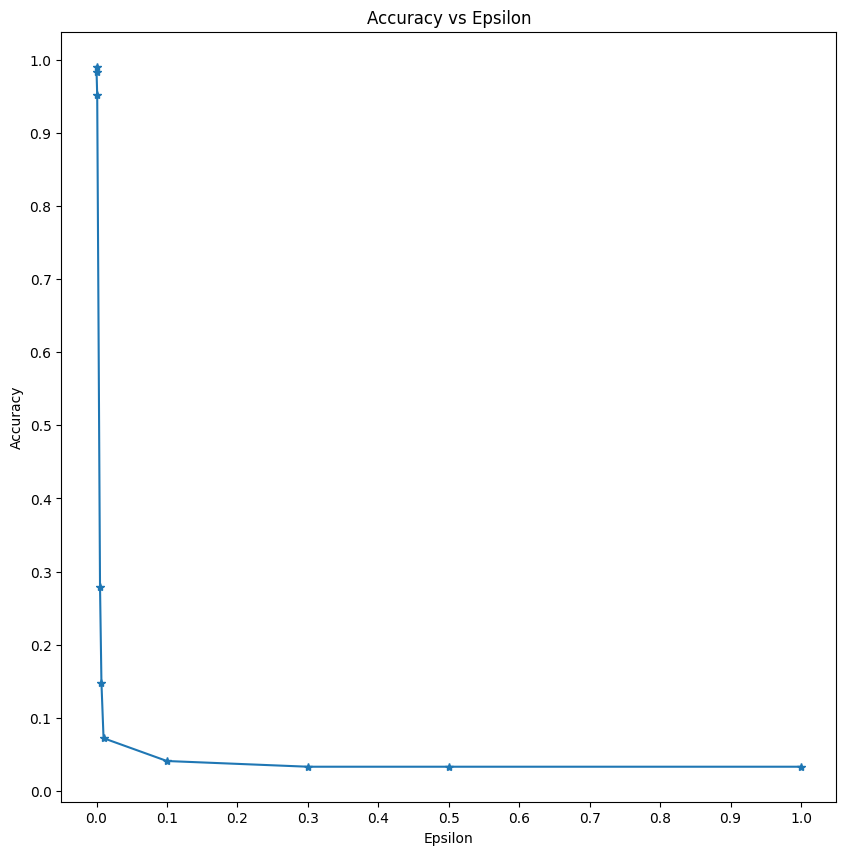

In [ ]:
def plot_accuracy(epsilons, accuracies):
    plt.figure(figsize=(10,10))
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    plt.close()

plot_accuracy(epsilons, accuracies)

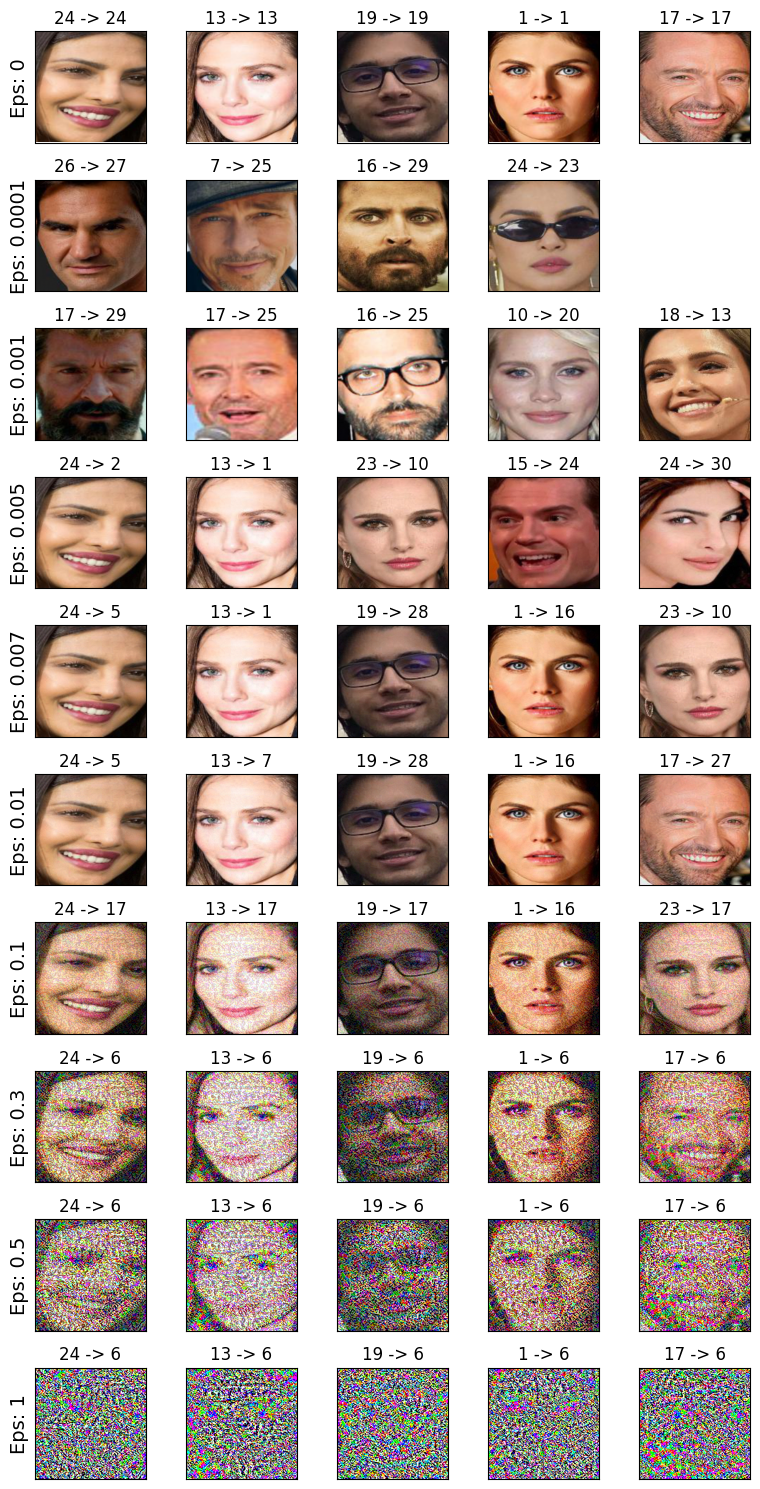

In [ ]:
def plot_examples(examples, epsilons, max_examples=5):
    """
    Grafica ejemplos de imágenes adversariales para cada valor de epsilon.

    Parameters:
    - examples: Lista de ejemplos adversariales para cada valor de epsilon.
    - epsilons: Lista de valores de epsilon.
    - max_examples: Número máximo de ejemplos a graficar para cada valor de epsilon.
    """
    cnt = 0
    plt.figure(figsize=(8, 15))  # Establecer el tamaño de la figura

    for i in range(len(epsilons)):
        num_examples = len(examples[i])  # Número de ejemplos disponibles para este epsilon
        for j in range(max_examples):
            cnt += 1
            plt.subplot(len(epsilons), max_examples, cnt)  # Crear un subplot
            plt.xticks([], [])  # Eliminar las marcas del eje x
            plt.yticks([], [])  # Eliminar las marcas del eje y
            if j == 0:
                plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)  # Etiquetar el eje y con el valor de epsilon
            
            # Verificar si hay un ejemplo para graficar
            if j < num_examples:
                orig, adv, ex = examples[i][j]
                plt.title(f"{orig} -> {adv}")  # Establecer el título con las etiquetas original y adversarial
                ex = np.clip(ex, 0, 1)  # Asegurarse de que los datos de la imagen estén en el rango [0, 1]
                plt.imshow(ex.transpose(1, 2, 0))  # Graficar la imagen adversarial
            else:
                # Dejar el espacio en blanco
                plt.title("")  # Sin título
                plt.imshow(np.ones((32, 32, 3)))  # Ejemplo de imagen en blanco (fondo blanco)
                plt.axis('off')  # Apagar el eje
    plt.tight_layout()  # Ajustar los subplots para que se ajusten al área de la figura
    plt.show()  # Mostrar la gráfica
    # plt.savefig(save_path)  # Descomentar para guardar la gráfica en un archivo
    plt.close()  # Cerrar la gráfica

plot_examples(examples, epsilons, max_examples=5)